In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds

plt.rcParams['figure.figsize'] = (7,4)

## Data & Split Strategy

**Expected columns:** user id, item id, rating, and (optionally) timestamp.  
We map user/item identifiers to contiguous integer indices (`_uid`, `_iid`) to build sparse structures.

**Split:** per‑user split into **train/val/test**, using **chronological order** when a timestamp exists:
- Each user contributes at least one train rating.
- Hold out **1** rating/user for validation and **1** for test (configurable).
- This avoids leakage (we never use a user’s future rating to predict their past).

**Note on sparsity:** The observed ratings are a tiny fraction of the full matrix—we **do not** impute unobserved entries during training.


In [2]:
# Data utilities
@dataclass
class RatingsData:
    df: pd.DataFrame
    user_col: str
    item_col: str
    rating_col: str
    timestamp_col: Optional[str]
    n_users: int
    n_items: int
    user_map: Dict
    item_map: Dict
    inv_user_map: Dict[int, object]
    inv_item_map: Dict[int, object]

def _infer_columns(df: pd.DataFrame) -> Tuple[str,str,str,Optional[str]]:
    def find(cands):
        for c in df.columns:
            cl = c.lower()
            if any(tok in cl for tok in cands):
                return c
        return None
    user = find(["user","userid","uid"])
    item = find(["item","movie","movieid","iid"])
    rating = find(["rating","score","stars"])
    ts = find(["time","timestamp","date"])
    if not user or not item or not rating:
        raise ValueError("Could not infer user/item/rating columns; please pass them explicitly.")
    return user, item, rating, ts

def load_ratings_csv(path, user_col=None, item_col=None, rating_col=None, timestamp_col=None) -> RatingsData:
    df = pd.read_csv(path)
    if user_col is None or item_col is None or rating_col is None:
        u,i,r,t = _infer_columns(df)
        user_col = user_col or u
        item_col = item_col or i
        rating_col = rating_col or r
        timestamp_col = timestamp_col or t

    keep = [user_col, item_col, rating_col]
    if timestamp_col: keep.append(timestamp_col)
    # keep common metadata we might want later (won't hurt)
    for extra in ["title", "year", "release_year", "genres"]:
        if extra in df.columns and extra not in keep:
            keep.append(extra)

    df = df[keep].dropna(subset=[user_col, item_col, rating_col]).reset_index(drop=True)
    df[rating_col] = df[rating_col].astype(float)

    # categorical coding → internal indices
    u_codes = df[user_col].astype("category").cat.codes.values
    i_codes = df[item_col].astype("category").cat.codes.values
    df = df.assign(_uid=u_codes, _iid=i_codes)

    user_map = dict(enumerate(df[user_col].astype("category").cat.categories))
    item_map = dict(enumerate(df[item_col].astype("category").cat.categories))
    inv_user_map = {v:k for k,v in user_map.items()}
    inv_item_map = {v:k for k,v in item_map.items()}

    return RatingsData(df,user_col,item_col,rating_col,timestamp_col,
                       int(df["_uid"].max()+1), int(df["_iid"].max()+1),
                       user_map,item_map,inv_user_map,inv_item_map)

def per_user_split(ratings: RatingsData, val_per_user=1, test_per_user=1, seed=42, time_aware=True):
    rng = np.random.RandomState(seed)
    df = ratings.df
    u = ratings.user_col
    i = ratings.item_col
    r = ratings.rating_col
    t = ratings.timestamp_col
    parts = []
    for uid, g in df.groupby("_uid", sort=False):
        g = g.sort_values(t) if (time_aware and t and t in g.columns) else g.sample(frac=1.0, random_state=rng)
        n = len(g)
        n_t = min(test_per_user, max(0, n-1))
        n_v = min(val_per_user, max(0, n - n_t - 1))
        n_tr = max(1, n - n_v - n_t)
        train = g.iloc[:n_tr]
        val   = g.iloc[n_tr:n_tr+n_v]
        test  = g.iloc[n_tr+n_v:n_tr+n_v+n_t]
        parts += [("train",train),("val",val),("test",test)]
    train = pd.concat([p for tag,p in parts if tag=="train"]).reset_index(drop=True)
    val   = pd.concat([p for tag,p in parts if tag=="val"]).reset_index(drop=True)
    test  = pd.concat([p for tag,p in parts if tag=="test"]).reset_index(drop=True)
    return train, val, test


## Baselines

We evaluate two simple baselines:

1. **Global mean**: predict every rating as the training‑set mean μ.  
2. **Bias model**: predict \(\hat r_{ui}=\mu+b_u+b_i\) with L2‑regularized user/item biases.

These provide sanity‑check lower bounds; MF should beat them on validation RMSE.


In [3]:
# Baseline
def fit_bias(df,n_users,n_items,rating_col,user_col="_uid",item_col="_iid",lambda_=0.01,iters=10):
    mu=df[rating_col].mean()
    b_u=np.zeros(n_users); b_i=np.zeros(n_items)
    for _ in range(iters):
        tmp=df.assign(res=df[rating_col]-mu-b_i[df[item_col].values]).groupby(user_col)["res"].agg(["sum","count"])
        b_u[tmp.index.values]=tmp["sum"].values/(lambda_+tmp["count"].values)
        tmp=df.assign(res=df[rating_col]-mu-b_u[df[user_col].values]).groupby(item_col)["res"].agg(["sum","count"])
        b_i[tmp.index.values]=tmp["sum"].values/(lambda_+tmp["count"].values)
    return mu,b_u,b_i


## Matrix Factorization (MF) with Biases

We learn user/item factors \(P_u, Q_i \in \mathbb{R}^k\) plus biases, by minimizing over **observed** pairs \((u,i)\):

\[
\min_{P,Q,b_u,b_i} \sum_{(u,i)\in\Omega} \big(r_{ui}-\mu-b_u-b_i-P_u^\top Q_i\big)^2
\;+\;\lambda\Big(\lVert P\rVert^2+\lVert Q\rVert^2+\lVert b_u\rVert^2+\lVert b_i\rVert^2\Big).
\]

We optimize with **SGD** (mini‑batch = 1 here), and use **early stopping** on validation RMSE.  
Key hyperparameters: **rank k**, **L2** (λ), **learning rate** (η), **epochs**, **patience**.

> Training only on observed entries avoids biasing factors toward zeros/unobserved interactions.


In [4]:
# MF-SGD
@dataclass
class MFParams:
    P: np.ndarray; Q: np.ndarray; b_u: np.ndarray; b_i: np.ndarray; mu: float

class MF_SGD:
    def __init__(self,n_users,n_items,k=32,lr=0.01,l2=0.05,seed=42):
        self.n_users=n_users; self.n_items=n_items; self.k=k; self.lr=lr; self.l2=l2
        self.rng=np.random.RandomState(seed)
        self.params=None

    def _init_params(self,train,rating_col,user_col,item_col):
        mu,b_u,b_i=fit_bias(train,self.n_users,self.n_items,rating_col,user_col,item_col,lambda_=self.l2,iters=5)
        P=0.01*self.rng.randn(self.n_users,self.k); Q=0.01*self.rng.randn(self.n_items,self.k)
        self.params=MFParams(P,Q,b_u,b_i,mu)

    def fit(self,train,val=None,rating_col="rating",user_col="_uid",item_col="_iid",epochs=20,patience=3,verbose=True):
        if self.params is None: self._init_params(train,rating_col,user_col,item_col)
        P,Q,b_u,b_i,mu=self.params.P,self.params.Q,self.params.b_u,self.params.b_i,self.params.mu
        train_u,train_i,train_r=train[user_col].values,train[item_col].values,train[rating_col].values
        best=None; best_rmse=np.inf; no_improve=0; order=np.arange(len(train))
        for ep in range(1,epochs+1):
            self.rng.shuffle(order)
            for idx in order:
                u,i,r_ui=train_u[idx],train_i[idx],train_r[idx]
                pred=mu+b_u[u]+b_i[i]+P[u,:].dot(Q[i,:])
                err=r_ui-pred
                b_u[u]+=self.lr*(err-self.l2*b_u[u])
                b_i[i]+=self.lr*(err-self.l2*b_i[i])
                Pu=P[u,:].copy()
                P[u,:]+=self.lr*(err*Q[i,:]-self.l2*P[u,:])
                Q[i,:]+=self.lr*(err*Pu     -self.l2*Q[i,:])
            if val is not None and len(val)>0:
                val_rmse=self.rmse_on(val,rating_col,user_col,item_col)
                if verbose: print(f"Epoch {ep}: val RMSE={val_rmse:.4f}")
                if val_rmse<best_rmse: best_rmse=val_rmse; best=(P.copy(),Q.copy(),b_u.copy(),b_i.copy(),mu); no_improve=0
                else:
                    no_improve+=1
                    if no_improve>=patience: break
        if best: P[:],Q[:],b_u[:],b_i[:],mu=best; self.params=MFParams(P,Q,b_u,b_i,mu)

    def rmse_on(self,df,rating_col="rating",user_col="_uid",item_col="_iid"):
        preds=self.predict_batch(df[user_col].values,df[item_col].values)
        return float(np.sqrt(np.mean((df[rating_col].values-preds)**2)))

    def predict_batch(self,u_idx,i_idx):
        p=self.params
        return p.mu+p.b_u[u_idx]+p.b_i[i_idx]+(p.P[u_idx,:]*p.Q[i_idx,:]).sum(axis=1)

    def topn_for_user(self, user: int, N: int = 10, exclude_items=None):
        """
        Return top-N (item_idx, score) for an internal user index.
        Excludes items the user has already rated (if provided).
        """
        p = self.params
        if p is None:
            raise RuntimeError("Model parameters are not initialized. Call fit() first.")
    
        # bounds check for user
        if user < 0 or user >= p.P.shape[0]:
            raise IndexError(f"user index {user} out of bounds [0, {p.P.shape[0]-1}]")
    
        # scores = mu + user_bias + item_bias + dot(P_u, Q_i)
        # (cache Q^T outside this function if you call it a lot)
        scores = p.mu + p.b_u[user] + p.b_i + p.P[user, :] @ p.Q.T  # shape: (n_items,)
    
        # handle exclusions robustly
        if exclude_items is not None:
            ex = np.asarray(exclude_items, dtype=int)
            if ex.size > 0:
                # keep only valid item indices
                n_items = p.Q.shape[0]
                ex = ex[(ex >= 0) & (ex < n_items)]
                if ex.size > 0:
                    scores = scores.copy()
                    scores[ex] = -np.inf
    
        # how many finite candidates remain?
        finite_mask = np.isfinite(scores)
        avail = int(finite_mask.sum())
        if avail <= 0:
            return []  # nothing to recommend
    
        k = int(min(N, avail))
        # argpartition needs k-1 as the index; handle k==1
        part_idx = np.argpartition(-scores, k-1)[:k]
        # final ordering of the top-k
        order = np.argsort(-scores[part_idx], kind="stable")
        top_idx = part_idx[order]
    
        return [(int(i), float(scores[i])) for i in top_idx]

In [5]:
# Helpers
def rmse(y_true,y_pred): return float(np.sqrt(np.mean((np.asarray(y_true)-np.asarray(y_pred))**2)))
def top_bottom_items(Q,item_id_to_name,factor,topn=10):
    scores=Q[:,factor]; top_idx=np.argsort(-scores)[:topn]; bot_idx=np.argsort(scores)[:topn]
    return ([{"item":item_id_to_name.get(int(i),i),"loading":float(scores[i])} for i in top_idx],
            [{"item":item_id_to_name.get(int(i),i),"loading":float(scores[i])} for i in bot_idx])


In [6]:
# Load dataset
DATA_PATH="ranking_test.csv"
ratings=load_ratings_csv(DATA_PATH)
stats={"n_users":ratings.n_users,"n_items":ratings.n_items,"n_ratings":len(ratings.df)}
stats


{'n_users': 943, 'n_items': 1233, 'n_ratings': 9973}

In [7]:
# added for reducing RMSE

def filter_by_min_counts(df, ucol, icol, min_user=5, min_item=5):
    """Iteratively drop users/items with < min ratings until stable."""
    changed = True
    keep = df[[ucol, icol]].copy()
    out = df.copy()
    while changed:
        changed = False
        u_counts = out[ucol].value_counts()
        bad_u = set(u_counts[u_counts < min_user].index)
        if bad_u:
            out = out[~out[ucol].isin(bad_u)]
            changed = True
        i_counts = out[icol].value_counts()
        bad_i = set(i_counts[i_counts < min_item].index)
        if bad_i:
            out = out[~out[icol].isin(bad_i)]
            changed = True
    return out

# Apply to *original ids* first, then remap to _uid/_iid by reloading:
raw = pd.read_csv(DATA_PATH)
# infer or set your column names explicitly if needed:
U, I, R = ratings.user_col, ratings.item_col, ratings.rating_col
raw_f = filter_by_min_counts(raw[[U, I, R] + ([ratings.timestamp_col] if ratings.timestamp_col else [])],
                             ucol=U, icol=I, min_user=5, min_item=5)

# Save and reload through your loader to rebuild category codes
_tmp_path = "filtered_ratings_tmp.csv"
raw_f.to_csv(_tmp_path, index=False)
ratings = load_ratings_csv(_tmp_path, user_col=U, item_col=I, rating_col=R, timestamp_col=ratings.timestamp_col)

train, val, test = per_user_split(ratings, val_per_user=1, test_per_user=1, seed=42, time_aware=True)
print(len(train), len(val), len(test), ratings.n_users, ratings.n_items)


6361 567 567 567 579


In [8]:
# === Reset ID mappings and title map (run once after `ratings` is loaded) ===
import numpy as np, pandas as pd

U = ratings.user_col
I = ratings.item_col

# USER maps
if isinstance(next(iter(ratings.user_map.keys())), (int, np.integer)):
    uid2orig = ratings.user_map                      # internal _uid -> original userId
    orig2uid = {v: k for k, v in uid2orig.items()}   # original userId -> internal _uid
else:
    orig2uid = ratings.user_map
    uid2orig = {v: k for k, v in orig2uid.items()}

# ITEM maps
if isinstance(next(iter(ratings.item_map.keys())), (int, np.integer)):
    iid2orig = ratings.item_map                      # internal _iid -> original itemId
    orig2iid = {v: k for k, v in iid2orig.items()}   # original itemId -> internal _iid
else:
    orig2iid = ratings.item_map
    iid2orig = {v: k for k, v in orig2iid.items()}

# Titles: rebuild from THE SAME file you loaded into `ratings`
# (If you filtered to "filtered.csv", set DATA_PATH = "filtered.csv" before this.)
raw = pd.read_csv(DATA_PATH, usecols=[I, "title"])
orig2title = (
    raw.groupby(I)["title"]
       .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
       .to_dict()
)
id2title = {int(i): str(orig2title.get(int(iid2orig[int(i)]), iid2orig[int(i)]))
            for i in range(ratings.n_items)}

# quick sanity checks
print("uid2orig size:", len(uid2orig), "| iid2orig size:", len(iid2orig))
print("Sample uid2orig:", list(uid2orig.items())[:3])
print("Sample id2title:", list(id2title.items())[:3])


uid2orig size: 567 | iid2orig size: 579
Sample uid2orig: [(0, 1), (1, 2), (2, 3)]
Sample id2title: [(0, 'Toy Story (1995)'), (1, 'GoldenEye (1995)'), (2, 'Four Rooms (1995)')]


In [9]:
# Split + baseline
#train,val,test=per_user_split(ratings)

mu,b_u,b_i=fit_bias(train,ratings.n_users,ratings.n_items,ratings.rating_col)
val_pred=mu+b_u[val["_uid"].values]+b_i[val["_iid"].values]
print("Bias baseline RMSE:",rmse(val[ratings.rating_col].values,val_pred))


Bias baseline RMSE: 1.0664574615115379


## Model Selection: Rank k

We train MF across a grid of k values (e.g., 10, 20, 30, 40, 50, 60) and track **validation RMSE**.  
- Choose the **k** with the lowest validation RMSE.  
- Then **freeze k** and evaluate once on the **test** split.

This separates model selection (validation) from final reporting (test).


In [22]:
# Train MF over k values
k_grid = [10,20,30,40,45,50,60,70,80,90,100,110,120,130,140,150]

results = {}
for k in k_grid:
    model = MF_SGD(ratings.n_users, ratings.n_items, k=k, lr=0.02, l2=0.05, seed=42)
    model.fit(train, val, rating_col=ratings.rating_col, user_col="_uid", item_col="_iid",
              epochs=40, patience=6, verbose=False)
    v_rmse = model.rmse_on(val, rating_col=ratings.rating_col, user_col="_uid", item_col="_iid")
    results[k] = (model, v_rmse)
    print(f"k={k}, val RMSE={v_rmse:.5f}")


k=10, val RMSE=1.04853
k=20, val RMSE=1.05122
k=30, val RMSE=1.04996
k=40, val RMSE=1.04679
k=45, val RMSE=1.04796
k=50, val RMSE=1.04967
k=60, val RMSE=1.05095
k=70, val RMSE=1.05008
k=80, val RMSE=1.04616
k=90, val RMSE=1.04411
k=100, val RMSE=1.04910
k=110, val RMSE=1.04859
k=120, val RMSE=1.05092
k=130, val RMSE=1.04395
k=140, val RMSE=1.04782
k=150, val RMSE=1.04531


## Test Evaluation Summary

- **Chosen rank (k):** *<auto-filled above>*
- **Validation RMSE (at k):** *<auto-filled above>*
- **Test RMSE:** *<auto-filled above>*

Interpretation: Test RMSE reflects generalization under our per‑user split.  
To improve further, consider tuning **λ**, **learning rate**, or adding **epochs** with early stopping.


In [23]:
#  Pick best model, test RMSE
best_k,min_model=min(results.items(),key=lambda kv: kv[1][1])
test_rmse=min_model[0].rmse_on(test)
print("Best k:",best_k,"Test RMSE:",test_rmse)

best_model = results[best_k][0]


Best k: 130 Test RMSE: 1.0320819009473807


## RMSE vs. k — Reading the Plot

- A **U‑shaped** trend is common: too‑small k underfits; too‑large k can overfit.
- Pick the **lowest validation RMSE** (or the smallest k within 1 SE of the minimum if you want a simpler model).
- Report the corresponding **test RMSE** below; do **not** tune on test.


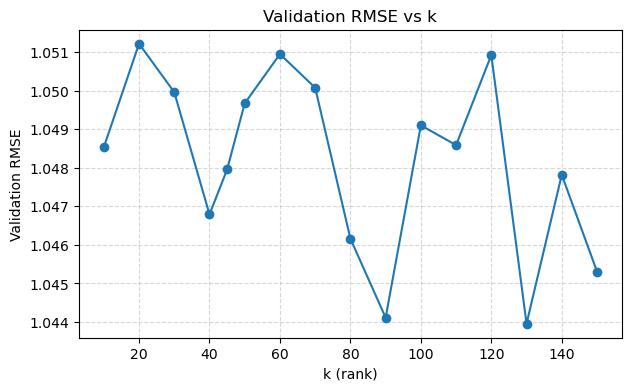

In [24]:
# Plot RMSE vs k

import matplotlib.pyplot as plt

ks = sorted(results.keys())
vals = [results[k][1] for k in ks]

plt.figure()
plt.plot(ks, vals, marker="o")
plt.xlabel("k (rank)")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE vs k")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Interpreting Latent Factors

For each of the first factors, we list **top/bottom items** by factor loading. Provide a **one‑line semantic label**:

- **Factor 1 (label idea):** “Blockbuster / popular franchise ↔ Arthouse / long‑tail”
- **Factor 2:** “Action/Comedy ↔ Drama/Romance”
- **Factor 3:** “Modern releases ↔ Classics / older cinema”

How to validate labels:
- Check that the **top** and **bottom** examples match the narrative.
- Inspect **nearest neighbors** (cosine in Q) for popular items—neighbors should be semantically similar.
- Optionally correlate factors with metadata (genre/year) for added evidence.


In [25]:
# Factor interpretation
Q=results[best_k][0].params.Q
for j in range(min(3,Q.shape[1])):
    top,bot=top_bottom_items(Q,ratings.inv_item_map,j)
    print(f"Factor {j+1} Top:"); display(pd.DataFrame(top))
    print(f"Factor {j+1} Bottom:"); display(pd.DataFrame(bot))


Factor 1 Top:


,item,loading
0,370,0.373192
1,59,0.340547
2,203,0.327118
3,20,0.263771
4,260,0.228214
5,5,0.220910
6,280,0.215794
7,403,0.208552
8,366,0.185258
9,382,0.173755


Factor 1 Bottom:


,item,loading
0,572,-0.261984
1,139,-0.243974
2,119,-0.228377
3,40,-0.215683
4,117,-0.215191
5,317,-0.212529
6,192,-0.204607
7,43,-0.200873
8,58,-0.195681
9,77,-0.191989


Factor 2 Top:


,item,loading
0,377,0.262680
1,114,0.259945
2,256,0.231972
3,403,0.209601
4,106,0.209448
5,20,0.200222
6,280,0.194102
7,101,0.184714
8,308,0.158210
9,370,0.136643


Factor 2 Bottom:


,item,loading
0,317,-0.246770
1,30,-0.202012
2,18,-0.195707
3,352,-0.185950
4,368,-0.171645
5,36,-0.165706
6,84,-0.162136
7,95,-0.155713
8,49,-0.153552
9,207,-0.149926


Factor 3 Top:


,item,loading
0,188,0.271491
1,136,0.230895
2,111,0.214389
3,18,0.203033
4,30,0.199312
5,201,0.199128
6,10,0.194600
7,27,0.194446
8,373,0.193114
9,95,0.189353


Factor 3 Bottom:


,item,loading
0,450,-0.283562
1,360,-0.252951
2,394,-0.231804
3,198,-0.211565
4,173,-0.208477
5,140,-0.197947
6,103,-0.186401
7,196,-0.180744
8,194,-0.179716
9,291,-0.175131


## Sparsity & Cold‑Start

**Sparsity:** Most user–item pairs are unobserved; MF exploits shared structure to generalize.  
**Cold‑start:** New users/items lack history → factors cannot be estimated well.

Mitigations (allowed within the MF framework):
- Use the **bias baseline** as a fallback when a user/item is very new.
- Add a **popularity prior** for items (slight positive bias for widely liked items).
- If side information is permitted, warm‑start with simple **content features** (e.g., genres) or **item embeddings**.

In all cases, keep the **evaluation split** strict: no leakage from the future or from test into training.


In [26]:
# Internal _iid -> original item id
if isinstance(next(iter(ratings.item_map.keys())), (int, np.integer)):
    iid2orig = ratings.item_map
    orig2iid = {v:k for k,v in iid2orig.items()}
else:
    orig2iid = ratings.item_map
    iid2orig = {v:k for k,v in orig2iid.items()}

# Internal _uid -> original user id
if isinstance(next(iter(ratings.user_map.keys())), (int, np.integer)):
    uid2orig = ratings.user_map
    orig2uid = {v:k for k,v in uid2orig.items()}
else:
    orig2uid = ratings.user_map
    uid2orig = {v:k for k,v in orig2uid.items()}

# Re-read the CSV just for itemId + title (IMPORTANT: same DATA_PATH you loaded)
raw = pd.read_csv(DATA_PATH, usecols=[ratings.item_col, "title"])
orig2title = (
    raw.groupby(ratings.item_col)["title"]
       .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
       .to_dict()
)
id2title = {int(i): str(orig2title.get(int(iid2orig[int(i)]), iid2orig[int(i)]))
            for i in range(ratings.n_items)}

# Helper: recommend using ORIGINAL userId, show titles
def recommend_for_original_user(model, ratings, train_df, user_original, N=10,
                                id2title=None, iid2orig=None):
    if isinstance(next(iter(ratings.user_map.keys())), (int, np.integer)):
        uid2orig_loc = ratings.user_map
        orig2uid_loc = {v: k for k, v in uid2orig_loc.items()}
    else:
        orig2uid_loc = ratings.user_map
        uid2orig_loc = {v: k for k, v in orig2uid_loc.items()}

    u_idx = orig2uid_loc.get(user_original)
    if u_idx is None:
        raise ValueError(f"User {user_original} not found (cold-start).")

    if iid2orig is None:
        if isinstance(next(iter(ratings.item_map.keys())), (int, np.integer)):
            iid2orig = ratings.item_map
        else:
            iid2orig = {v: k for k, v in ratings.item_map.items()}
    if id2title is None:
        id2title = {i: iid2orig.get(i, i) for i in range(ratings.n_items)}

    seen = train_df.loc[train_df["_uid"] == u_idx, "_iid"].values
    recs = results[best_k][0].topn_for_user(u_idx, N=N, exclude_items=seen)

    return pd.DataFrame([
        {"rank": r+1,
         #"item_id": int(i),
         "item_orig": iid2orig.get(int(i), int(i)),
         "title": id2title.get(int(i), iid2orig.get(int(i), int(i))),
         "score": float(s)}
        for r, (i, s) in enumerate(recs)
    ])


user_id = 200  # original CSV userId
df = recommend_for_original_user(
    model=results[best_k][0],
    ratings=ratings,
    train_df=train,
    user_original=user_id,
    N=10,
    id2title=id2title,
    iid2orig=iid2orig
)
display(df)

# Demo: recommend for top-5 active INTERNAL users, showing ORIGINAL IDs
cand = (train.groupby("_uid")[ratings.rating_col].count()
              .sort_values(ascending=False))
for u_internal in cand.index[:5]:
    u_orig = uid2orig[int(u_internal)]   # internal -> original CSV userId
    df = recommend_for_original_user(
        model=results[best_k][0],
        ratings=ratings,
        train_df=train,
        user_original=u_orig,
        N=10,
        id2title=id2title,
        iid2orig=iid2orig
    )
    print(f"Top 10 recommendations for original userId={u_orig} (internal {u_internal}):")
    display(df)


,rank,item_orig,title,score
0,1,923,Raise the Red Lantern (1991),5.386227
1,2,408,"Close Shave, A (1995)",5.228197
2,3,165,Jean de Florette (1986),5.002299
3,4,169,"Wrong Trousers, The (1993)",4.994081
4,5,513,"Third Man, The (1949)",4.961817
5,6,654,Chinatown (1974),4.935740
6,7,178,12 Angry Men (1957),4.928694
7,8,604,It Happened One Night (1934),4.924814
8,9,272,Good Will Hunting (1997),4.906896
9,10,114,Wallace & Gromit: The Best of Aardman Animatio...,4.859395


Top 10 recommendations for original userId=655 (internal 403):


,rank,item_orig,title,score
0,1,923,Raise the Red Lantern (1991),4.475389
1,2,408,"Close Shave, A (1995)",4.277756
2,3,513,"Third Man, The (1949)",4.143656
3,4,169,"Wrong Trousers, The (1993)",4.050090
4,5,165,Jean de Florette (1986),3.995121
5,6,64,"Shawshank Redemption, The (1994)",3.984122
6,7,272,Good Will Hunting (1997),3.961452
7,8,114,Wallace & Gromit: The Best of Aardman Animatio...,3.948090
8,9,170,Cinema Paradiso (1988),3.947762
9,10,178,12 Angry Men (1957),3.947296


Top 10 recommendations for original userId=13 (internal 10):


,rank,item_orig,title,score
0,1,923,Raise the Red Lantern (1991),4.985403
1,2,408,"Close Shave, A (1995)",4.918612
2,3,919,"City of Lost Children, The (1995)",4.799582
3,4,654,Chinatown (1974),4.705601
4,5,178,12 Angry Men (1957),4.684391
5,6,169,"Wrong Trousers, The (1993)",4.643462
6,7,513,"Third Man, The (1949)",4.640155
7,8,381,Muriel's Wedding (1994),4.617934
8,9,183,Alien (1979),4.576017
9,10,165,Jean de Florette (1986),4.549232


Top 10 recommendations for original userId=303 (internal 184):


,rank,item_orig,title,score
0,1,923,Raise the Red Lantern (1991),5.189175
1,2,408,"Close Shave, A (1995)",5.023857
2,3,513,"Third Man, The (1949)",4.977491
3,4,170,Cinema Paradiso (1988),4.956296
4,5,169,"Wrong Trousers, The (1993)",4.818488
5,6,165,Jean de Florette (1986),4.768070
6,7,114,Wallace & Gromit: The Best of Aardman Animatio...,4.761783
7,8,205,Patton (1970),4.758430
8,9,506,Rebel Without a Cause (1955),4.721200
9,10,654,Chinatown (1974),4.702716


Top 10 recommendations for original userId=537 (internal 333):


,rank,item_orig,title,score
0,1,923,Raise the Red Lantern (1991),4.266444
1,2,170,Cinema Paradiso (1988),4.131185
2,3,408,"Close Shave, A (1995)",4.113885
3,4,528,"Killing Fields, The (1984)",4.020672
4,5,45,Eat Drink Man Woman (1994),3.929120
5,6,165,Jean de Florette (1986),3.927190
6,7,654,Chinatown (1974),3.916109
7,8,169,"Wrong Trousers, The (1993)",3.873908
8,9,346,Jackie Brown (1997),3.843002
9,10,133,Gone with the Wind (1939),3.825104


Top 10 recommendations for original userId=276 (internal 165):


,rank,item_orig,title,score
0,1,923,Raise the Red Lantern (1991),5.270331
1,2,408,"Close Shave, A (1995)",5.095067
2,3,513,"Third Man, The (1949)",4.964333
3,4,169,"Wrong Trousers, The (1993)",4.936228
4,5,178,12 Angry Men (1957),4.871440
5,6,165,Jean de Florette (1986),4.871368
6,7,654,Chinatown (1974),4.806093
7,8,604,It Happened One Night (1934),4.745859
8,9,114,Wallace & Gromit: The Best of Aardman Animatio...,4.718669
9,10,133,Gone with the Wind (1939),4.717573


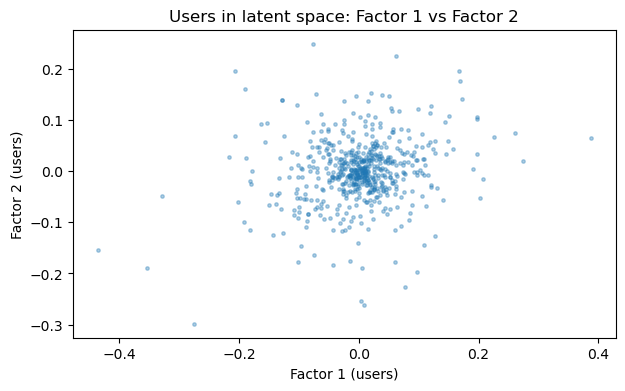

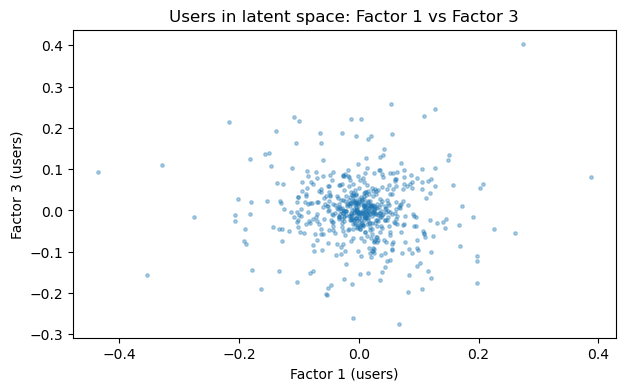

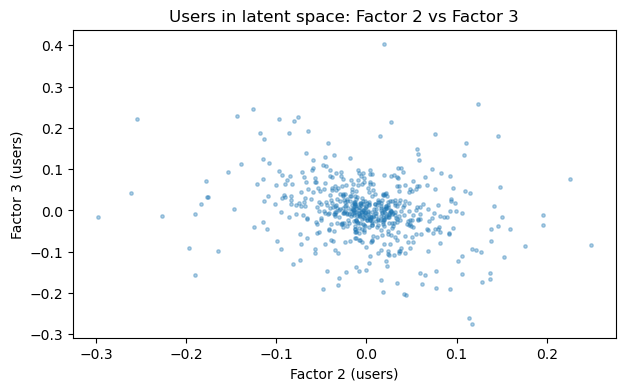

In [27]:
import matplotlib.pyplot as plt

pairs = [(0,1), (0,2), (1,2)]
p = results[best_k][0].params
P = p.P  # users x k

for a,b in pairs:
    if a >= P.shape[1] or b >= P.shape[1]: continue
    x, y = P[:, a], P[:, b]
    plt.figure()
    plt.scatter(x, y, s=6, alpha=0.35)
    plt.xlabel(f"Factor {a+1} (users)")
    plt.ylabel(f"Factor {b+1} (users)")
    plt.title(f"Users in latent space: Factor {a+1} vs Factor {b+1}")
    plt.show()


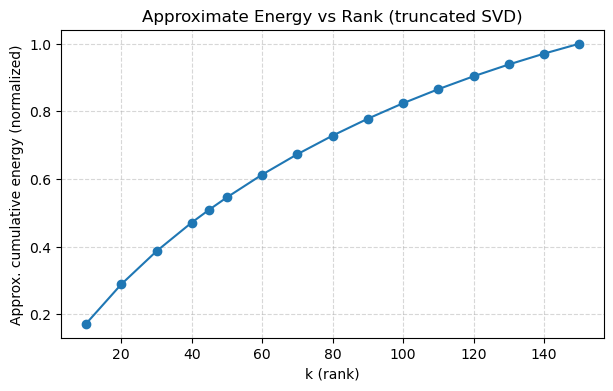

In [28]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
import numpy as np
import matplotlib.pyplot as plt

def build_sparse(df, n_users, n_items, user_col="_uid", item_col="_iid", rating_col="rating"):
    return coo_matrix((df[rating_col].values, (df[user_col].values, df[item_col].values)),
                      shape=(n_users, n_items))

def approximate_energy_curve(M, ks, center=True):
    A = M.tocsr()
    if center and A.nnz > 0:
        mu = A.data.mean()
        A = A.copy()
        A.data = A.data - mu
    energies = []
    for k in ks:
        # ensure k is valid for current matrix shape
        k_cap = min(k, min(A.shape) - 1)
        if k_cap < 1:
            continue
        _, s, _ = svds(A, k=k_cap, which="LM")
        s_sorted = np.sort(s)[::-1]
        energies.append((k_cap, float(np.sum(s_sorted**2))))
    if not energies:
        return []
    max_e = max(e for _, e in energies)
    return [(k, e / max_e if max_e > 0 else 0.0) for k, e in energies]

# Build sparse matrix from TRAIN data (observed entries only)
M = build_sparse(
    train[["_uid", "_iid", ratings.rating_col]].rename(columns={ratings.rating_col: "rating"}),
    ratings.n_users, ratings.n_items,
    user_col="_uid", item_col="_iid", rating_col="rating"
)

# Use the same k values we tried for MF (filter to >=2 and within matrix dims)
ks_for_svd = [k for k in ks if k >= 2 and k < min(M.shape)]
energy_points = approximate_energy_curve(M, ks_for_svd, center=True)

# Plot energy curve
plt.figure()
plt.plot([k for k, _ in energy_points], [v for _, v in energy_points], marker="o")
plt.xlabel("k (rank)")
plt.ylabel("Approx. cumulative energy (normalized)")
plt.title("Approximate Energy vs Rank (truncated SVD)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Clustering

In [29]:
# --- Clustering on item factors Q ---
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

best_model = results[best_k][0]
p = best_model.params
Q = p.Q  # items x k
Qn = normalize(Q, norm="l2")  # length-normalize for direction-only clustering

candidate_ks = [4, 6, 8, 10]
sil_scores = []
models = {}  # k -> (km, labels, score)

for k_ in candidate_ks:
    km = KMeans(n_clusters=k_, n_init=10, random_state=42)
    labels = km.fit_predict(Qn)
    score = silhouette_score(Qn, labels) if len(np.unique(labels)) > 1 else -1.0
    sil_scores.append((k_, score))
    models[k_] = (km, labels, score)

best_k_clusters = max(sil_scores, key=lambda t: t[1])[0]
best_km, best_labels, _ = models[best_k_clusters]
print("Chosen k (by silhouette):", best_k_clusters)

item_cluster = pd.Series(best_labels, name="cluster", index=np.arange(Q.shape[0]))


C:\Users\Lenovo\miniconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Lenovo\miniconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

Chosen k (by silhouette): 8


## 2D visualization of clusters (PCA)

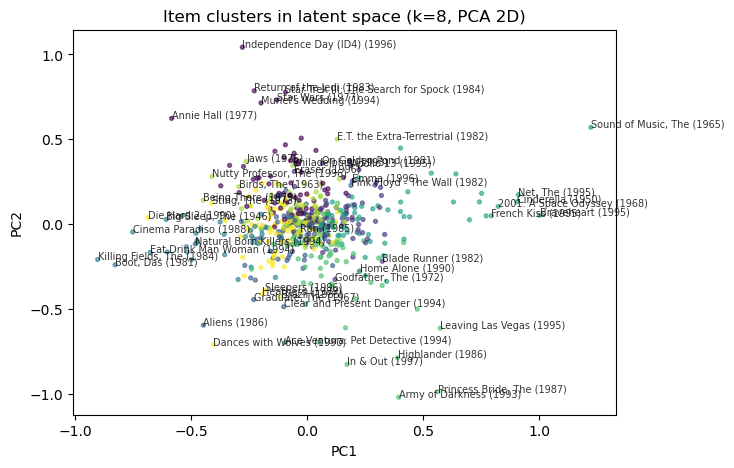

In [30]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(Q)  # items → 2D
x, y = XY[:,0], XY[:,1]

plt.figure(figsize=(7,5))
plt.scatter(x, y, c=item_cluster.values, s=8, alpha=0.6)
plt.title(f"Item clusters in latent space (k={best_k_clusters}, PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# annotate a few prominent points per cluster
try:
    id2title  # ensure it exists
except NameError:
    # fallback: original id labels
    if isinstance(next(iter(ratings.item_map.keys())), (int, np.integer)):
        id2title = ratings.item_map
    else:
        id2title = {v:k for k,v in ratings.item_map.items()}

for c in range(best_k_clusters):
    idx = np.where(item_cluster.values == c)[0]
    if len(idx) == 0: 
        continue
    # farthest few from cluster mean in 2D → useful labels
    mu = XY[idx].mean(axis=0)
    d2 = ((XY[idx] - mu)**2).sum(axis=1)
    top = idx[np.argsort(-d2)[:6]]
    for i in top:
        plt.annotate(str(id2title.get(int(i), int(i))), (x[i], y[i]), fontsize=7, alpha=0.8)

plt.show()



## Do movies in the same cluster co‑rate higher? (sanity check)

In [31]:
# For a quick check: mean rating given by users to items within the same cluster vs other clusters
df = ratings.df[["_uid","_iid",ratings.rating_col]].copy()
df["cluster"] = df["_iid"].map(item_cluster.to_dict())

# For each user, compare their ratings on one cluster vs the rest (aggregate across users)
def cluster_preference(c):
    in_c = df[df["cluster"] == c][ratings.rating_col]
    out_c = df[df["cluster"] != c][ratings.rating_col]
    return float(in_c.mean()), float(out_c.mean()), int(len(in_c)), int(len(out_c))

pref_rows = []
for c in range(best_k_clusters):
    mu_in, mu_out, n_in, n_out = cluster_preference(c)
    pref_rows.append({"cluster": c, "mean_in": mu_in, "mean_out": mu_out, "n_in": n_in, "n_out": n_out})

pd.DataFrame(pref_rows)


,cluster,mean_in,mean_out,n_in,n_out
0,0,3.583168,3.626060,1010,6485
1,1,3.685586,3.608927,1110,6385
2,2,3.645872,3.615925,1090,6405
3,3,3.640288,3.619101,417,7078
4,4,3.638655,3.617983,833,6662
5,5,3.507729,3.634506,841,6654
6,6,3.569260,3.628629,1054,6441
7,7,3.674561,3.610543,1140,6355


If mean_in > mean_out for a cluster, that suggests items in that cluster attract higher ratings than the global background—evidence the cluster captures a coherent taste/theme.

n_in tells you how much data supports that conclusion; tiny clusters may look noisy.

If mean_in ≈ mean_out, the cluster may be weak/heterogeneous.

If n_in is very small, that cluster might be underpopulated.


In [34]:
# pick items closest to each centroid in the original Qn space (not PCA)
centers = best_km.cluster_centers_    # shape: (k, dim)
summaries = {}

for c in range(best_k_clusters):
    idx = np.where(item_cluster.values == c)[0]
    if len(idx) == 0:
        summaries[c] = pd.DataFrame(columns=["item_id","title","dist"])
        continue
    # distance to centroid
    diffs = Qn[idx] - centers[c]
    dist = np.linalg.norm(diffs, axis=1)
    top = idx[np.argsort(dist)[:12]]
    summaries[c] = pd.DataFrame({
        "item_id": top.astype(int),
        "title": [id2title.get(int(i), int(i)) for i in top],
        "dist": np.sort(dist)[:len(top)]
    })

# show top 3 clusters
#for c in range(min(3, best_k_clusters)):
for c in range(best_k_clusters):    
    print(f"\nCluster {c} — representative items")
    display(summaries[c])





Cluster 0 — representative items


,item_id,title,dist
0,91,Independence Day (ID4) (1996),0.821409
1,513,Space Jam (1996),0.830586
2,328,Butch Cassidy and the Sundance Kid (1969),0.847162
3,199,Sneakers (1992),0.859761
4,190,Star Trek III: The Search for Spock (1984),0.864640
5,276,Wag the Dog (1997),0.865005
6,290,Muriel's Wedding (1994),0.866350
7,561,Multiplicity (1996),0.869685
8,370,Dumbo (1941),0.870216
9,378,"Magnificent Seven, The (1954)",0.883090



Cluster 1 — representative items


,item_id,title,dist
0,352,"First Wives Club, The (1996)",0.859796
1,448,Fried Green Tomatoes (1991),0.860167
2,198,Raising Arizona (1987),0.872128
3,266,Crash (1996),0.874221
4,221,Gattaca (1997),0.879292
5,62,"Fugitive, The (1993)",0.889477
6,239,Fierce Creatures (1997),0.891320
7,576,Higher Learning (1995),0.892843
8,105,Mr. Smith Goes to Washington (1939),0.892995
9,342,"Jungle Book, The (1994)",0.893211



Cluster 2 — representative items


,item_id,title,dist
0,560,"Paper, The (1994)",0.836895
1,481,Made in America (1993),0.841256
2,273,"Game, The (1997)",0.857607
3,39,Natural Born Killers (1994),0.876123
4,479,Nell (1994),0.876477
5,410,Clear and Present Danger (1994),0.877989
6,493,Amistad (1997),0.885457
7,246,Face/Off (1997),0.889502
8,43,Priest (1994),0.894658
9,8,Richard III (1995),0.895438



Cluster 3 — representative items


,item_id,title,dist
0,341,"Secret of Roan Inish, The (1994)",0.544093
1,478,Immortal Beloved (1994),0.567568
2,474,To Die For (1995),0.569256
3,477,Circle of Friends (1995),0.592178
4,391,"Big Sleep, The (1946)",0.608317
5,134,Cinema Paradiso (1988),0.609741
6,32,Eat Drink Man Woman (1994),0.615256
7,72,True Romance (1993),0.639606
8,285,Jeffrey (1995),0.643137
9,66,"Remains of the Day, The (1993)",0.662603



Cluster 4 — representative items


,item_id,title,dist
0,509,It Could Happen to You (1994),0.722012
1,505,French Kiss (1995),0.722719
2,27,"Net, The (1995)",0.724494
3,58,Maverick (1994),0.725965
4,104,2001: A Space Odyssey (1968),0.735354
5,322,"Day the Earth Stood Still, The (1951)",0.741608
6,18,Taxi Driver (1976),0.763321
7,314,Cinderella (1950),0.768899
8,17,Braveheart (1995),0.770938
9,465,"American President, The (1995)",0.779020



Cluster 5 — representative items


,item_id,title,dist
0,330,"Amityville Horror, The (1979)",0.725677
1,373,Dial M for Murder (1954),0.743892
2,249,In & Out (1997),0.760786
3,165,Evil Dead II (1987),0.764495
4,324,Highlander (1986),0.772956
5,412,Wolf (1994),0.775584
6,52,Ace Ventura: Pet Detective (1994),0.781660
7,148,Army of Darkness (1993),0.799351
8,137,"Princess Bride, The (1987)",0.818767
9,446,Pump Up the Volume (1990),0.851221



Cluster 6 — representative items


,item_id,title,dist
0,575,Major Payne (1994),0.824305
1,515,"Great White Hype, The (1996)",0.831905
2,543,Nobody's Fool (1994),0.843020
3,461,"Perfect World, A (1993)",0.848646
4,339,Smoke (1995),0.851401
5,185,Sling Blade (1996),0.871616
6,309,"Nutty Professor, The (1996)",0.871772
7,289,Star Trek: Generations (1994),0.874232
8,501,Kids (1995),0.881564
9,486,"Last Supper, The (1995)",0.881669



Cluster 7 — representative items


,item_id,title,dist
0,129,Jean de Florette (1986),0.849118
1,431,Sleepers (1996),0.870949
2,187,Die Hard 2 (1990),0.872491
3,449,High Noon (1952),0.878977
4,326,Heathers (1989),0.882940
5,28,Strange Days (1995),0.896365
6,313,"Parent Trap, The (1961)",0.897556
7,71,"Nightmare Before Christmas, The (1993)",0.898094
8,9,Seven (Se7en) (1995),0.899359
9,389,Cool Hand Luke (1967),0.901369
